# PCA

## Model Specification

There are two kinds of mathematical formulations for PCA. 

**Linear Manifold Approximation**

Suppose we have $N$ data points in the $p$-dimension space: $x_1, \dots, x_N$. Imagine we have a linear manifold parametrized by $\eta$:

$$f(\eta)=\mu+V_q\eta,$$

where $\mu$ is a location vector in $\mathbb{R}^p$, $V_q\in\mathbb{R}^{p\times q}$ with $q$ orthogonal unit vectors as columns, and $\lambda$ is a $q$-dimensional vector. This is an affine hyperplane of rank $q$. Suppose the task is to approximate the $N$ data points by this $q$-dimensional manifold by least square:

$$\min_{\mu, \{\eta_i\}, V_q}\sum_{i=1}^N\left|x_i-\mu-V_q\eta_i\right|^2.$$

The optimal values for $\mu$ and $\eta_i$ are given by 

$$\hat{\mu}=\bar{x}$$
$$\hat{\eta_i}=V_q^{\top}(x_i-\bar{x})$$

and $V_q$ is given by the first $q$ columns of $V$ in the **Singular Value Decomposition (SVD)** of $X\in\mathbb{R}^{N\times p}$:

$$X=UDV^{\top}.$$

Here $U\in\mathbb{R}^{N\times p}$ is an orthogonal matrix, $V\in\mathbb{R}^{p\times p}$ also an orthogonal matrix and $D\in\mathbb{R}^{p\times p}$ a positive definite diagonal matrix.

- The diagonal elements of $D$ are known as **singular values**.
- Columns of $V$ are called **principle directions** or **loadings**.
- The columns of $UD$ are the **principle components**. The first $q$ elements of the $N$ rows of $UD$ give $\hat{\eta}_i, i=1,\dots, N$. That is, dimension reduction from $p$ to $q$ is done by representing $x_i$ by $\hat{\eta}_i$, and $q$ principle components are needed. Each element of the principle components is called a **score**, which is the projected value of the corresponding data point onto the principle direction.

**The Linear Combination that has the largest variation**

Suppose the data has been normalized, with each of the $p$ predictors having $0$ mean and unit variance. The first column $v_1$ of $V$ above is the optimal solution to the following optimization problem

$$\max_v v^{\top}X^{\top}Xv$$

$$s.t. v^{\top}v=1$$

The second column $v_2$ of $V$ satistifies unit vector orthogonal to $v_1$ and has the largest variance.

### Variants and Generalizations

- **Principal curves and surfaces** generalize PCA, in that PCA projects data points to hyperplanes, while principle curves and surfaces project points to non-linear manifolds.

- [Spectral clustering and kernel PCA](spectral_clustering_and_kernel_PCA.ipynb) also generalize PCA, in that features are blown up to higher dimension before PCA is applied. This [post](https://stats.stackexchange.com/questions/94463/what-are-the-advantages-of-kernel-pca-over-standard-pca) explains why this blown-up-to-high-dimension nonlinearity is needed. See also the discussion near Figure 14.29 in ESL.

- We often interpret principle components by examining the direction vectors or loading, to see which variables play a role. Often this interpretation is made easier if the loadings are sparse. This motivates the **sparse PCA technique**. There are many different formulations for the sparse PCA problem. 
   - The one implemented in **`sklearn`** solves the following optimization problem.

    $$(U^{\ast}, V^{\ast})=arg\min_{U,V}\frac{1}{2}||X-UV||_2^2+\alpha||V||_1,$$

        subject to $||U_k||_2=1$ for all $0\leq k < n_{components}$. 
   - The one in ESL, taken from Zou, et al. (2006), resembles the elastic net, with both L1 and L2 penalization.

## Theoretical Properties

### Advantages

- The variations in the first few principle components usually account for much of the total variations, especially in cases where there are significant correlations among the $p$ predictors, or equivalently, when $X$ has a high condition number.

### Disadvantages

- PCA is only linear. When the clustering or variation is nonlinear, PCA tends to fail.
- PCA is sensitive in predictor scales. In fact, all predictors are recommended to be normalized before PCA is carried out; otherwise, there can be some contrived example where the high mean masks the true maximum variation in the data point.
- PCA, as an unsupervised learning tool, may not be sensitive to $y$ values.

### Relation to Other Models

When the **autoencoder** only does not have a linear activation, the latent components learned are the principle components. More precisely, suppose $W$ has $K$ rows in the below graph. There is no guarantee that rows of $W$ will exactly correspond to the first $K$ principle directions, but together they should span the sub space spanned by the first $K$ principle directions. Intuitively it is straightforward why $W$ should relate to the principle directions, because it needs to capture the most variations amongst $X$. But the definition of 'variation' here seems subtly different from above.

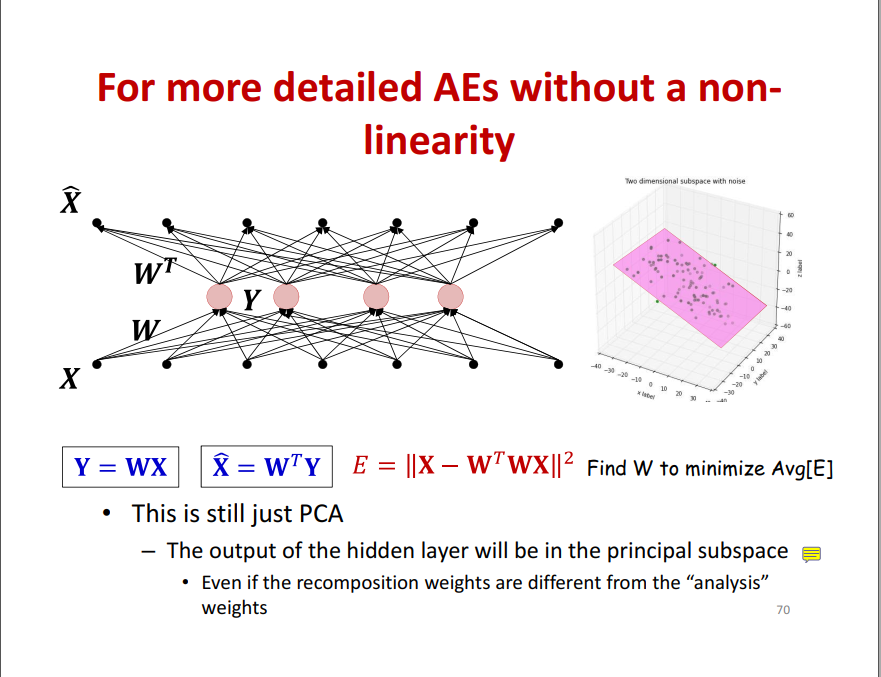

## Empirical Performance

### Advantages and Disadvantages

## Implementation Details and Practical Tricks

**PCA in sklearn**

In [1]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2, whiten=False)
pca.fit(X)
print(pca.explained_variance_ratio_)  
#print(pca.singular_values_)  

[ 0.99244289  0.00755711]


AttributeError: 'PCA' object has no attribute 'singular_values_'

**Selected Parameters**

- **`n_components`**: 

Number of components to keep. If n_components is not set all components are kept: `n_components == min(n_samples, n_features)`
 - If `n_components == ‘mle’` and `svd_solver == ‘full’`, Minka’s MLE is used to guess the dimension 
 - If `0 < n_components < 1` and `svd_solver == ‘full’`, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by `n_components` 
 - `n_components` cannot be equal to `n_features` for `svd_solver == ‘arpack’`.
 
- **`whiten`**:

When `True` (`False` by default) the `components_ vectors` are multiplied by the square root of `n_samples` and then divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.

Whitening will remove some information from the transformed signal (the relative variance scales of the components) but can sometime improve the predictive accuracy of the downstream estimators by making their data respect some hard-wired assumptions.

- **`svd_solver`**: (read the papers in Further Reading section to fully understand how this works)

 - `auto` :
The solver is selected by a default policy based on `X.shape` and `n_components`: 
    - If the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient `‘randomized’` method is enabled. 
    - Otherwise the exact full SVD is computed and optionally truncated afterwards.

 - `full` :
Run exact full SVD calling the standard `LAPACK` solver via `scipy.linalg.svd` and select the components by postprocessing

 - `arpack` :
Run SVD truncated to `n_components` calling `ARPACK` solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < X.shape[1]`.

 - `randomized` :
run randomized SVD by the method of Halko et al.

**Selected Attributes**

- **`components_`** : array, shape `(n_components, n_features)`

Principal directions in feature space, representing the projections of maximum variance in the data. The components are sorted by `explained_variance_`.

- **`explained_variance_`**: array, shape `(n_components,)`

The amount of variance explained by each of the selected components.

Equal to `n_components` largest eigenvalues of the covariance matrix of `X`.

**Selected Methods**

- **`fit_transform(X,[y])`**: the fitted principle components of `X`.

**`sparsePCA` in sklearn**

The `sparsePCA` component seems to have the same interface as the `PCA` component above.

Mini-batch sparse PCA (`MiniBatchSparsePCA`) is a variant of SparsePCA that is faster but less accurate. The increased speed is reached by iterating over small chunks of the set of features, for a given number of iterations.

## Use Cases

- Use a linear manifold to approximate a set of $N$ points $x_i\in\mathbb{R}^p$, where the $N$ points are approximated by points in $q\leq p$ dimensions.
- By extension of the above, principle components are a useful tool for **dimension reduction**, **compression** and **visualization**.
- After dimension reduction, sometimes a better clustering is possible.
- PCA can be used as a **pre-processing step**. For instance, to deal with colinearity in regression - if a few of the top PCA components represents high percentage of variance, it indicates high colinearity; see the discussion of PCR. Some other models may prefer predictors to be uncorrelated, which makes the principle components out of PCA desirable.

## Results Interpretation, Metrics and Visualization

Three ways to visualize and better understand PCA

- Display the principle directions $V$, or loadings in the parameters space.

- Show the first two components or the first two scores, i.e. the first two columns of $U^{\top}D$, resulting in a scatterplot. If the first two dimensions of loadings are also shown on the same graph, it is called a 'biplot' as in Stanford online course. Alternatively, you can also choose a few components and produce scatterplot from one to another; see Figure 14.39 in ESL for an example.

- Display data points that attain extreme scroes on the components; see Figure 14.23 in ESL.

In understanding the percentage of variance explained by the principle component, we can also plot the cumulative variance explained by the first number of component, or the so-called **scree plot**. The crutch point can be used to determine the number of principle components. 

## References
- ESL, Section 14.5.1, 14.5.4, 14.5.5
- [scikit-learn Document 2.5](http://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca)

### Further Reading

- Thomas P. Minka: Automatic Choice of Dimensionality for PCA. NIPS 2000: 598-604
- M. Tipping and C. Bishop, Probabilistic Principal Component Analysis, Journal of the Royal Statistical Society, Series B, 61, Part 3, pp. 611-622
- Finding structure with randomness: Stochastic algorithms for constructing approximate matrix decompositions Halko, et al., 2009 (arXiv:909) 
- A randomized algorithm for the decomposition of matrices Per-Gunnar Martinsson, Vladimir Rokhlin and Mark Tygert
- Zou, H., Hastie, T. and Tibshirani, R. (2006). Sparse principal component analysis, Journal of Computational and Graphical Statistics 15(2): 265-28.

## Misc.